In [2]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import math
import numpy as np
import colorsys
from scipy import optimize as sciopt
import os
import lmfit
import uncertainties as u

Welcome to JupyROOT 6.18/04


In [3]:
plt.style.use(hep.style.ATLAS)
plt.style.use({"axes.labelsize":'36', 'lines.linewidth':'2', 'lines.markersize':'2'})

### Set-Up Histograms

In [4]:
class DataSet:
    """
    Dataset object has:
   
    name: name of the dataset (ie 1A, 1B, ...)

    long_name: long form name of the dataset (ie 60h, HighKick, ...)

    energy_range: the energy upper and lower cutoffs in MeV [lower, upper]

    hists: root histograms of y vs t for each calorimeter. Has structure {"randomized": [list of histograms], "unrandomized": [list of histograms]}

    dfs: pandas dataframes of y vs t for each calorimeter. Has structure {"randomized": [list of dataframes], "unrandomized": [list of dataframes]}
    """
    
    def __init__(self, name = None, long_name = None, file = None, energy_range = [0, 99999999999]):
        self.name         = name
        self.long_name    = long_name
        self.file         = file
        self.hists        = None
        self.dfs          = None
        self.energy_range = energy_range
        self.func1_params = None
        self.func2_params = None
        

    def _calo_df(self, hist, step):
        
        data = pd.DataFrame(columns=['TimeBin', 'Mean', 'MeanError', 'SD', 
                                     'SDError', 'Var', 'VarError','Npoints', 
                                     'RMS', 'RMSError'])
        
        for index in range(0, hist.GetNbinsX()-step, step):
            a = dict()

            proj = hist.ProjectionY("_py", index, index+step)

            #a['TimeBin']      = index*(hist.GetXaxis().GetXmax()/hist.GetNbinsX())
            a['TimeBin']      = hist.GetXaxis().GetBinCenter(index)
            a['Mean']         = (proj.GetMean() - 3) * 25.2
            a['MeanError']    = proj.GetMeanError() * 25.2
            a['SD']           = proj.GetStdDev() * 25.2
            a['SDError']      = proj.GetStdDevError() * 25.2
            a['Var']          = (proj.GetStdDev() ** 2) * (25.2 ** 2)
            a['VarError']     = 2 * abs(proj.GetStdDev()) * proj.GetStdDevError() * (25.2 ** 2)
            a['Npoints']      = proj.GetEntries()
            a['RMS']          = proj.GetRMS() * 25.2
            a['RMSError']     = proj.GetRMSError() * 25.2

            data.loc[index] = a
                
        return data

    
    def build_hists(self):
        calo_hists = {}
        rand_hists = {}

        for i in range(1, 25):
            calo = self.file.Get("verticalPosition/clusters" + str(i)).Clone(self.name + "_calo_" + str(i))
            rand = self.file.Get("verticalPosition/randclusters" + str(i)).Clone(self.name + "_rand_calo_" + str(i))

            calo.SetAxisRange(self.energy_range[0], self.energy_range[1], "y")
            rand.SetAxisRange(self.energy_range[0], self.energy_range[1], "y")
            calo_hists[i] = calo.Project3D("zx")
            rand_hists[i] = rand.Project3D("zx")
            
        return {"unrandomized": calo_hists, "randomized": rand_hists}
    

    def build_dfs(self, step):
        unrandomized = {}
        randomized = {}

        for caloNum, hist in self.hists['unrandomized'].items():
            unrandomized[caloNum] = self._calo_df(hist, step)
            
        for caloNum, hist in self.hists['randomized'].items():
            randomized[caloNum] = self._calo_df(hist, step)
            
        return {"unrandomized": unrandomized, "randomized":randomized}

In [5]:
def func0(t, c, m):
    return( c + m * t)


def func1(t, c, a, tau, m):
    return( c - a * (np.exp(-t/tau)) + m*t)


def func2(t, c, a, tauA, b, tauB):
    return( c - a * (np.exp(-t/tauA)) + b * (np.exp(t/tauB)) )


In [6]:
def fit_func1(df, fit_lim):
    """
    """
    model = lmfit.Model(func1)

    mean_params = {}        

    fit_data = df[(df['TimeBin'] > fit_lim[0]) & (df['TimeBin'] < fit_lim[1]) ][:]

    #Mean
    mean_result = model.fit(fit_data['Mean'], t=fit_data['TimeBin'], c=0.5, a=8, tau=7, m=0.0001, weights=1/fit_data['MeanError'])
    mean_cov = mean_result.covar
    """
    fig, ax = plt.subplots(1,1)

    ax.plot(df['TimeBin'], df['Mean'], linestyle='none', marker='o')
    ax.plot(fit_data['TimeBin'], mean_result.best_fit)
    ax.set_ylim(-3, 3);
    ax.set_xlim(0, 200);

    print(mean_result.fit_report())
    """

    for name, param in mean_result.params.items():
        mean_params[name] = param.value
    
    for index, name in enumerate(mean_result.params):
        mean_params[name + '_err'] = np.sqrt(mean_cov[index][index])
        
    mean_params['redchi'] = mean_result.redchi

    return mean_params

In [8]:
energy_lim = [1000, 2400]

sixtyhour = DataSet("1A", "60h", r.TFile("./60h.root"), energy_lim)
highkick  = DataSet("1B", "HighKick", r.TFile("./highkick.root"), energy_lim)
nineday   = DataSet("1C", "9day", r.TFile("./9day.root"), energy_lim)
endgame   = DataSet("1D", "EndGame", r.TFile("./endgame.root"), energy_lim)
run2C     = DataSet("2C", "run2C", r.TFile("./run2C.root"), energy_lim)

datasets = {"1A": sixtyhour, "1B":highkick, "1C":nineday, "1D":endgame, "2C": run2C}

for name, dataset in datasets.items():
    dataset.hists = dataset.build_hists()
    dataset.dfs = dataset.build_dfs(step=10)

In [9]:
rand_data = {}

for name, dataset in datasets.items():
    this_data = pd.DataFrame(columns = ['c', 'a', 'tau', 'm', 'c_err', 'a_err', 'tau_err', 'm_err', 'redchi', 'caloNum'])

    for caloNum, df in dataset.dfs['randomized'].items():
        p = fit_func1(df, fit_lim=[10, 200])
        p['caloNum'] = caloNum
        this_data.loc[caloNum-1] = p
        
    rand_data[dataset.name] = this_data
    
nor_data = {}

for name, dataset in datasets.items():
    this_data = pd.DataFrame(columns = ['c', 'a', 'tau', 'm', 'c_err', 'a_err', 'tau_err', 'm_err', 'redchi', 'caloNum'])

    for caloNum, df in dataset.dfs['unrandomized'].items():
        p = fit_func1(df, fit_lim=[10, 200])
        p['caloNum'] = caloNum
        this_data.loc[caloNum-1] = p
        
    nor_data[dataset.name] = this_data

In [15]:
"""
Plot for Tau
"""

fig, ax = plt.subplots(2,2)
fig.set_size_inches(25, 20)

for long_name, df in rand_data.items():
    ax[1][1].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[0][1].errorbar(df['caloNum'], df['tau'], yerr=df['tau_err'], label=long_name)
    
for long_name, df in nor_data.items():
    ax[1][0].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[0][0].errorbar(df['caloNum'], df['tau'], yerr=df['tau_err'], label=long_name)
    
ax[1][1].legend(loc=(1.25, 0.4), fontsize='x-large', labelspacing=1.5, framealpha=1);
ax[1][0].set_ylim(-1, 20)
ax[0][0].set_ylim(3, 8)
ax[1][1].set_ylim(-1, 20)
ax[0][1].set_ylim(3, 8)
ax[1][1].set_xlabel('calo number')
ax[1][1].set_ylabel(r'$chi^{2}$')
ax[0][1].set_ylabel('τ    (μs)')
ax[1][0].set_xlabel('calo number')
ax[1][0].set_ylabel(r'$chi^{2}$')
ax[0][0].set_ylabel('τ    (μs)')
ax[0][0].set_title('Without Randomization', fontsize=40)
ax[0][1].set_title('With Randomization', fontsize=40)
fig.tight_layout()

plt.savefig("params_tau.png", bbox_inches='tight')
plt.close()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [16]:
"""
Plot for m
"""

fig, ax = plt.subplots(2,2)
fig.set_size_inches(25, 20)

for long_name, df in rand_data.items():
    ax[1][1].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[0][1].errorbar(df['caloNum'], df['m'], yerr=df['m_err'], label=long_name)
    
for long_name, df in nor_data.items():
    ax[1][0].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[0][0].errorbar(df['caloNum'], df['m'], yerr=df['m_err'], label=long_name)
    
    
ax[0][0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0][1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[1][1].legend(loc=(1.25, 0.4), fontsize='x-large', labelspacing=1.5, framealpha=1);
ax[1][0].set_ylim(-1, 20)
ax[0][0].set_ylim(-0.00225, 0.001)
ax[1][1].set_ylim(-1, 20)
ax[0][1].set_ylim(-0.00225, 0.001)

ax[1][1].set_xlabel('calo number')
ax[1][1].set_ylabel(r'$chi^{2}$')
ax[0][1].set_ylabel('m    (mm/μs)')
ax[1][0].set_xlabel('calo number')
ax[1][0].set_ylabel(r'$chi^{2}$')
ax[0][0].set_ylabel('m    (mm/μs)')
ax[0][0].set_title('Without Randomization', fontsize=40)
ax[0][1].set_title('With Randomization', fontsize=40)
fig.tight_layout()

plt.savefig("params_m.png", bbox_inches='tight')
plt.close()

In [19]:
"""
Plot for C
"""
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)

run2C_data = rand_data['2C']

for name, df in rand_data.items():
    ax.errorbar(df['caloNum'], df['c'] - run2C_data['c'],
                yerr=(df['c_err'].pow(2) + run2C_data['c_err'].pow(2)).apply(np.sqrt), label=name)

#ax.legend(loc=0, fontsize='large', labelspacing=1.5, framealpha=1);
ax.set_ylim(-0.5, 2)
#ax.set_title('Difference in C parameter value compared to run2C fit', fontsize=40)
ax.set_xlabel('calo number')
ax.set_ylabel('Difference in C    (mm)')

fig.tight_layout()

plt.savefig("params_c.png", bbox_inches='tight')
plt.close()

In [19]:
"""
Plot for With Randomization
"""
fig, ax = plt.subplots(3,2)
fig.set_size_inches(20, 30)

for long_name, df in rand_data.items():
    ax[0][0].errorbar(df['caloNum'], df['c'], yerr=df['c_err'])
    ax[0][1].errorbar(df['caloNum'], df['a'], yerr=df['a_err'])
    ax[1][0].errorbar(df['caloNum'], df['tau'], yerr=df['tau_err'])
    ax[1][1].errorbar(df['caloNum'], df['m'], yerr=df['m_err'])
    ax[2][0].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[2][1].axis('off')
    
ax[0][0].set_ylim(-0.5, 3.5)
ax[0][1].set_ylim(0, 20)
ax[2][0].set_ylim(0, 17)
ax[1][0].set_ylim(3, 8)
ax[1][1].set_ylim(-0.00225, 0.001)

ax[1][1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[0][0].set_xlabel('calo number')
ax[0][1].set_xlabel('calo number')
ax[2][0].set_xlabel('calo number')
ax[1][0].set_xlabel('calo number')
ax[1][1].set_xlabel('calo number')

ax[0][0].set_ylabel('c    (mm)')
ax[0][1].set_ylabel('A    (mm)')
ax[2][0].set_ylabel(r'$chi^{2}$', fontsize=40)
ax[1][0].set_ylabel('τ    (μs)')
ax[1][1].set_ylabel('m    (mm/μs)')

fig.tight_layout()
fig.suptitle('With Randomization', fontsize=40, y=1.05)
ax[2][0].legend(loc=(1.5, 0), fontsize='x-large', labelspacing=1.5, framealpha=1);
plt.savefig("params_randomized", bbox_inches='tight')
plt.close()

In [20]:
"""
Plot for Without Randomization
"""
fig, ax = plt.subplots(3,2)
fig.set_size_inches(20, 30)

for long_name, df in nor_data.items():
    ax[0][0].errorbar(df['caloNum'], df['c'], yerr=df['c_err'])
    ax[0][1].errorbar(df['caloNum'], df['a'], yerr=df['a_err'])
    ax[1][0].errorbar(df['caloNum'], df['tau'], yerr=df['tau_err'])
    ax[1][1].errorbar(df['caloNum'], df['m'], yerr=df['m_err'])
    ax[2][0].plot(df['caloNum'], df['redchi'], label=long_name)
    ax[2][1].axis('off')
    
ax[0][0].set_ylim(-0.5, 3.5)
ax[0][1].set_ylim(0, 20)
ax[2][0].set_ylim(0, 17)
ax[1][0].set_ylim(3, 8)
ax[1][1].set_ylim(-0.00225, 0.001)

ax[1][1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[0][0].set_xlabel('calo number')
ax[0][1].set_xlabel('calo number')
ax[2][0].set_xlabel('calo number')
ax[1][0].set_xlabel('calo number')
ax[1][1].set_xlabel('calo number')

ax[0][0].set_ylabel('c    (mm)')
ax[0][1].set_ylabel('A    (mm)')
ax[2][0].set_ylabel(r'$chi^{2}$', fontsize=40)
ax[1][0].set_ylabel('τ    (μs)')
ax[1][1].set_ylabel('m    (mm/μs)')

fig.tight_layout()
fig.suptitle('Without Randomization', fontsize=40, y=1.05)
ax[2][0].legend(loc=(1.5, 0), fontsize='x-large', labelspacing=1.5, framealpha=1);
plt.savefig("params_unrandomized", bbox_inches='tight')
plt.close()

In [23]:
"""
Plot average tau vs dataset
"""

rand_averages = pd.DataFrame(columns = ['name', 'tau', 'error'])
i=0
for name, df in rand_data.items():
    df2 = df.copy(deep=True)
    tau = df2['tau'].mean()
    error = np.sqrt( df2['tau_err'].pow(2).sum() ) / 24
    
    rand_averages.loc[i] = {'name':name, 'tau':tau, 'error':error}
    i += 1
    
nor_averages = pd.DataFrame(columns = ['name', 'tau', 'error'])
i=0
for name, df in nor_data.items():
    df2 = df.copy(deep=True)
    tau = df2['tau'].mean()
    error = np.sqrt( df2['tau_err'].pow(2).sum() ) / 24
    
    nor_averages.loc[i] = {'name':name, 'tau':tau, 'error':error}
    i += 1
    
diffs = nor_averages.copy(deep=True)
diffs['tau'] = rand_averages['tau'] - nor_averages['tau']
diffs['error'] = ((rand_averages['error'].pow(2) + nor_averages['error'].pow(2))).apply(np.sqrt) / 2

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(30, 10)

ax[0].plot(nor_averages['name'], nor_averages['tau'], linestyle='none', marker='o', markersize=9, color='xkcd:blue')
ax[0].errorbar(nor_averages['name'], nor_averages['tau'], linestyle='none', yerr=nor_averages['error'], color='xkcd:blue')
ax[1].plot(rand_averages['name'], rand_averages['tau'], linestyle='none', marker='o', markersize=9, color='xkcd:red')
ax[1].errorbar(rand_averages['name'], rand_averages['tau'], linestyle='none', yerr=nor_averages['error'], color='xkcd:red')

ax[2].plot(diffs['name'], diffs['tau'], linestyle='none', marker='o', markersize=9, color='C2')
ax[2].errorbar(diffs['name'], diffs['tau'], yerr=diffs['error'], linestyle='none', color='C2')

ax[0].set_ylim(4.5, 6.5)
ax[1].set_ylim(4.5, 6.5)

ax[0].set_ylabel('Average τ    (μs)', fontsize=30)
ax[1].set_ylabel('Average τ    (μs)', fontsize=30)
ax[2].set_ylabel('Difference in Average τ    (μs)', fontsize=30)

ax[0].set_title('Without Randomization', fontsize=32)
ax[1].set_title('With Randomization', fontsize=32)
ax[2].set_title('With - Without Randomization', fontsize=32)

fig.tight_layout()

plt.savefig('params_tau_compare.png', bbox_inches='tight')
plt.close()

print(nor_averages)

  name       tau     error
0   1A  5.424966  0.066669
1   1B  5.661921  0.060680
2   1C  5.853784  0.061821
3   1D  5.324717  0.062920
4   2C  4.905715  0.036759


### Misc Stuff

In [12]:
avg = u.ufloat(0, 0)

taus = nor_data['run2C']['tau'].values
errors = nor_data['run2C']['tau_err'].values

print(taus)
print(errors)

for i in range(0, len(taus)):
    this_tau = u.ufloat(taus[i], errors[i])
    avg += this_tau
    
avg = avg / 24

print(avg)

[4.56023376 4.6159442  4.49730557 4.53305389 4.65604633 5.11767903
 4.94148087 4.59590117 5.11905614 4.75809904 4.76702094 5.27139056
 4.93840077 5.12958589 5.20399079 5.08541416 5.21959722 5.04258742
 5.18766252 5.02213979 4.84139162 4.96980737 4.91849636 4.74487738]
[0.14542634 0.20668082 0.16147099 0.15571887 0.18073051 0.24011118
 0.21425659 0.1777123  0.25599054 0.17512336 0.15946933 0.15750807
 0.18382056 0.16901345 0.16078763 0.18371245 0.18765444 0.14232918
 0.20626633 0.14990058 0.12775384 0.13332089 0.22342708 0.15306964]
4.91+/-0.04


<class 'ROOT.TH1D'>


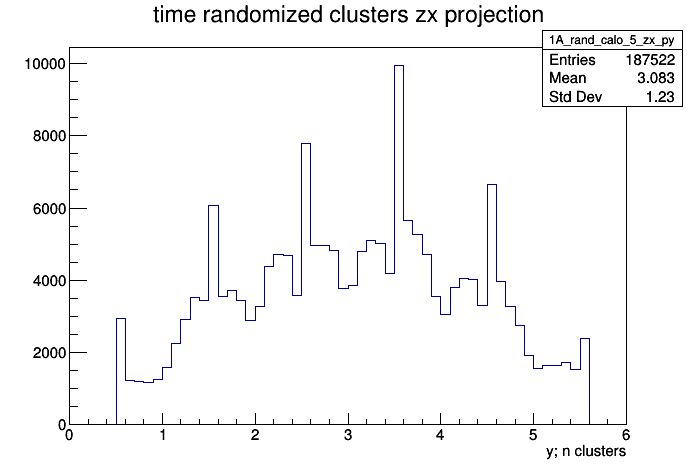

In [47]:
proj = datasets['1A'].hists['randomized'][5].ProjectionY("_py", 2000, 2010)
print(type(proj))
c = r.TCanvas()
proj.Draw("colz")
c.Draw()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


1000


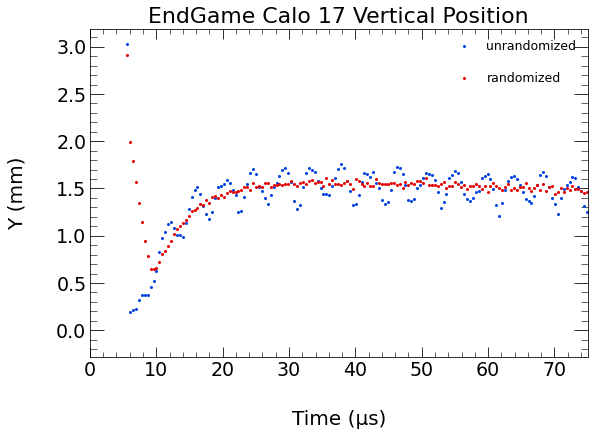

In [28]:
fig, ax = plt.subplots(1,1)
rand_data2 = datasets['1D'].dfs['randomized'][17]
nor_data2 = datasets['1D'].dfs['unrandomized'][17]

ax.plot(nor_data2['TimeBin'], nor_data2['Mean'], linestyle='none', marker='o', color='xkcd:blue', label='unrandomized')
ax.plot(rand_data2['TimeBin'], rand_data2['Mean'], linestyle='none', marker='o', color='xkcd:red', label='randomized')

ax.set_xlim(0, 75)
ax.set_ylabel('Y (mm)', fontsize=20);
ax.set_xlabel('Time (μs)', fontsize=20);
ax.legend(loc=0, fontsize='x-small', labelspacing=1.5, framealpha=1);
ax.set_title('EndGame Calo 17 Vertical Position', fontsize=22);

print(len(rand_data2['Mean']))

In [25]:
calo = endgame.file.Get("verticalPosition/clusters" + str(1)).Clone(endgame.name + "_test_calo_" + str(1))

In [26]:
type(calo)

ROOT.TH3F

In [27]:
type(endgame.hists['randomized'][1])

ROOT.TH2D

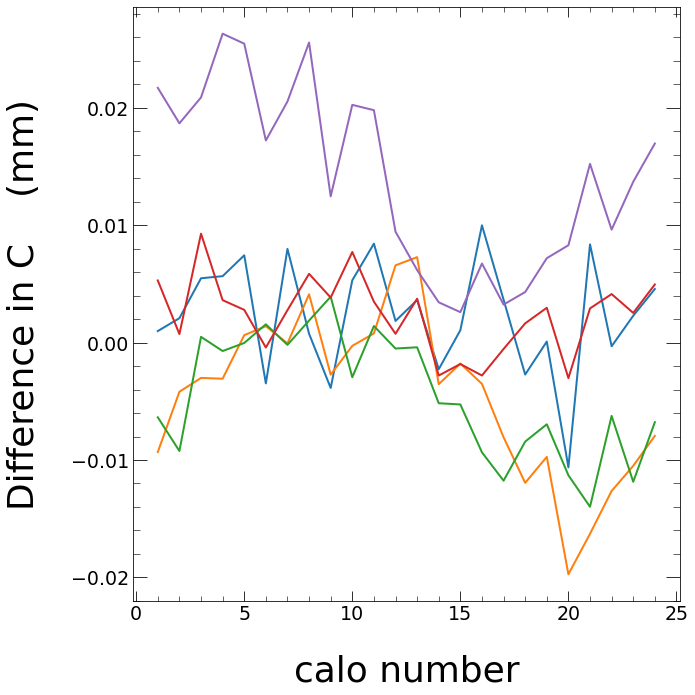

In [21]:
"""
Plot for C
"""
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)



for name, df in rand_data.items():
    ax.plot(df['caloNum'], df['c'] - nor_data[name]['c'])

#ax.legend(loc=0, fontsize='large', labelspacing=1.5, framealpha=1);
#ax.set_ylim(-0.5, 2)
#ax.set_title('Difference in C parameter value compared to run2C fit', fontsize=40)
ax.set_xlabel('calo number')
ax.set_ylabel('Difference in C    (mm)')

fig.tight_layout()

